In [6]:
import numpy as np
s = 1/2
d = int(2 * s + 1)

# Vector of the diagonal elements for the SZ operator
vecm = np.flip(np.arange(-s, s + 1))  # same as flip(-s:s) in MATLAB
SZ = np.diag(vecm, 0)

# Vector for SM operator (ladder down)
vec2 = vecm[:d-1]  # remove the last entry
vec3 = np.sqrt(s * (s + 1) - vec2 * (vec2 - 1))
SM = np.diag(vec3, k=-1)  # place vec3 in lower diagonal

# Construct SX and SY
SX = (SM + SM.T) / 2
SY = 1j * (SM.T - SM) / 2

print(vecm)

[ 0.5 -0.5]


In [25]:
import numpy as np
import scipy.sparse as sp

d = 100  # number of basis states for one oscillator

# Create vector
vec = np.sqrt(np.arange(d-1))

# Dense annihilation operators
A = np.diag(vec, k=1)  # shift up by 1
B = A.copy()

# Construct dense Hamiltonian
Hint = np.kron(A.T, B) + np.kron(A, B.T)

# Sparse version
vec_sp = sp.csr_matrix(vec)  # sparse row vector
A_sp = sp.diags(vec, offsets=1, shape=(d, d), format='csr')
B_sp = A_sp.copy()

# Construct sparse Hamiltonian
Hint_sp = sp.kron(A_sp.T, B_sp) + sp.kron(A_sp, B_sp.T)

# Show memory usage and formats
def show_size(name, obj):
    size = obj.data.nbytes if sp.issparse(obj) else obj.nbytes
    print(f"{name:<10}: type={type(obj).__name__:<25} shape={obj.shape}  memory={size/1024:.2f} KB")

show_size("vec", vec)
show_size("A", A)
show_size("Hint", Hint)
show_size("vec_sp", vec_sp)
show_size("A_sp", A_sp)
show_size("Hint_sp", Hint_sp)

vec       : type=ndarray                   shape=(99,)  memory=0.77 KB
A         : type=ndarray                   shape=(100, 100)  memory=78.12 KB
Hint      : type=ndarray                   shape=(10000, 10000)  memory=781250.00 KB
vec_sp    : type=csr_matrix                shape=(1, 99)  memory=0.77 KB
A_sp      : type=csr_matrix                shape=(100, 100)  memory=0.77 KB
Hint_sp   : type=csr_matrix                shape=(10000, 10000)  memory=150.06 KB


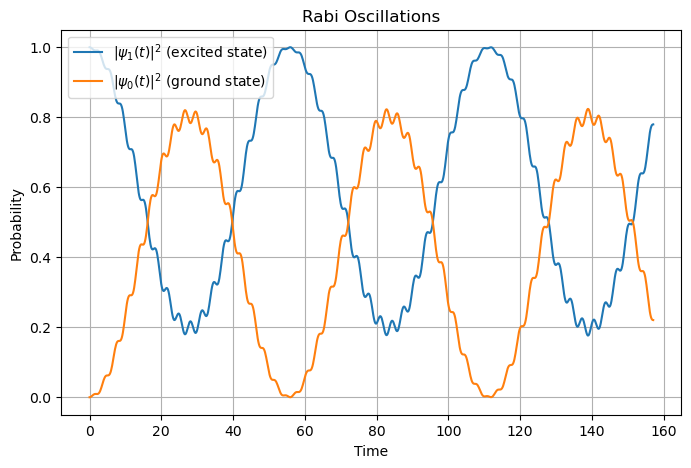

In [26]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define constants
w0 = 1.0            # Level splitting
Omega = 0.1         # Rabi frequency
wd = 0.95           # Driving frequency

# Define Hamiltonians
H0 = w0 * np.array([[1, 0], [0, 0]], dtype=complex)           # Bare Hamiltonian
H1 = Omega * np.array([[0, 1], [1, 0]], dtype=complex)        # Driving Hamiltonian

# Initial state: ground state
psi0 = np.array([0, 1], dtype=complex)

# Time span for integration
t_span = (0, 50 * np.pi)

# Define RHS of Schrödinger equation
def Hfun(t, psi):
    H = H0 + np.cos(wd * t) * H1
    return -1j * H @ psi  # Matrix-vector product

# Solve the ODE using SciPy's solve_ivp
sol = solve_ivp(
    Hfun,
    t_span,
    psi0,
    method='RK45',                     # ode45 equivalent
    t_eval=np.linspace(*t_span, 1000),# evaluation points for smoother plot
    rtol=1e-6,
    atol=1e-6
)

# Plot the population of the excited and ground states
T = sol.t
Y = sol.y.T  # Transpose to get time rows like MATLAB

plt.figure(figsize=(8, 5))
plt.plot(T, np.abs(Y[:, 1])**2, label=r'$|\psi_1(t)|^2$ (excited state)')
plt.plot(T, np.abs(Y[:, 0])**2, label=r'$|\psi_0(t)|^2$ (ground state)')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Rabi Oscillations')
plt.legend()
plt.grid(True)
plt.show()

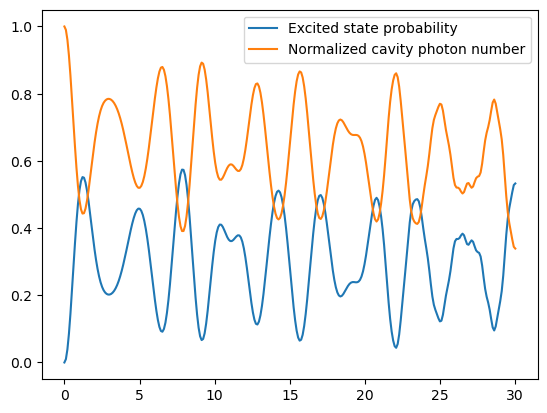

In [66]:
import numpy as np
from scipy.linalg import expm
from scipy.sparse import kron, eye, spdiags
from scipy.integrate import solve_ivp
from scipy.special import factorial 
import matplotlib.pyplot as plt

def Lfun(t, rho, L):
    return L @ rho  # Derivative of rho at time t

Da = 0.0  # Detuning of atom from driving field
DC = 0    # Detuning of cavity from driving field
g = 1     # Coupling
E = 0.0   # Strength of the external driving field
Gamma = 0.01  # Atomic decay rate
kappa = 0.001  # Cavity decay rate
alpha = 1.      # Initial coherent state amplitude
dc = 30        # Dimension of the cavity
d = 2 * dc     # Dimension of the whole system

# Create the vectors and operators
vec = np.sqrt(np.arange(1,dc))
A = np.diag(vec, 1)  # Annihilation operator for the cavity mode
SM = np.array([[0+1j*0.0, 0+1j*0.0], [1+1j*0.0, 0+1j*0.0]])  # sigma_- and sigma_+ operators for the atom
SP = SM.T
idc = np.eye(dc)
ida = np.eye(2)
Id = eye(d).tocsc()  # Identity matrix for the full system (as sparse)

# Hamiltonians
Ha = -Da * np.dot(SP, SM)  # Bare Hamiltonian of the atom
Hc = -DC * np.dot(A.T, A)  # Bare cavity Hamiltonian
Hint = g * (kron(SM, A.T) + kron(SP, A))  # Jaynes-Cummings coupling
Hdrive = 1j * E * (A.T - A)  # External driving field
H = kron(Ha, idc) + kron(ida, Hc) + Hint + kron(ida, Hdrive)  # Total Hamiltonian

# Liouville operator
LH = -1j * (kron(H, Id) - kron(Id, H.T))
LGamma = Gamma / 2 * (2 * kron(kron(SM, idc), kron(SP, idc).T) -
                        kron(kron(np.dot(SP, SM), idc), Id) - kron(Id, kron(np.dot(SP, SM), idc)))
Lkappa = kappa * (2 * kron(kron(ida, A), kron(ida, A.T).T) -
                    kron(kron(ida, np.dot(A.T, A)), Id) - kron(Id, kron(ida, np.dot(A.T, A))))
L = LH + LGamma + Lkappa  # Total Liouville operator

# Initial state: atom in the ground state, cavity in coherent state
psic = np.zeros(dc)
for x in range(dc):
    psic[x] = np.exp(-alpha**2 / 2) * alpha**x / np.sqrt(factorial(x))

psi0 = np.kron([0, 1.0+1j*0.0], psic)  # Tensor product for initial state
rho_ini = np.kron(psi0, np.conj(psi0))  # Initial density matrix

# Time evolution:
steps = 300
tspan = np.linspace(0, 30, steps)  # Time interval for integration
f = lambda t, rho: Lfun(t, rho, L)

# Solving the differential equation for rho
sol = solve_ivp(f, (tspan[0], tspan[-1]), rho_ini, t_eval=tspan, method='RK45', atol=1e-5, rtol=1e-5)

# Expectation values
trace_vec = np.reshape(np.eye(d), (d * d))  # Flatten the identity matrix into a row vector
Pe = np.zeros(steps)
Nc = np.zeros(steps)

for t in range(steps):
    Pe[t] = np.real(trace_vec @ kron(kron(np.dot(SP, SM), idc), Id) @ sol.y[:, t])
    Nc[t] = np.real(trace_vec @ kron(kron(ida, np.dot(A.T, A)), Id) @ sol.y[:, t])

# Plotting the results
plt.figure(1)
plt.plot(tspan, Pe, label='Excited state probability')
plt.plot(tspan, Nc / Nc[0], label='Normalized cavity photon number')
plt.legend()
plt.show()

In [58]:
import numpy as np
from scipy.linalg import null_space

# Assuming L is a NumPy array or SciPy sparse matrix
V0 = null_space(L)  # Computes an orthonormal basis for the null space of L
V0 = V0[:, 0]       # Take the first vector in the null space basis

# Assuming trace_vec is a row vector of shape (1, d*d)
# Make sure V0 is a column vector (d*d, 1)
rho0 = V0 / (trace_vec @ V0)

ValueError: Sparse matrices are not supported by this function. Perhaps one of the scipy.sparse.linalg functions would work instead.

In [71]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# Assume L is a dense or sparse matrix — convert to sparse if not already
#L_sparse = sp.csr_matrix(L)  # Compressed Sparse Row format
L_sparse = L

# Compute the eigenvector corresponding to the eigenvalue closest to 0
eigenvalue, eigenvector = spla.eigs(L_sparse, k=3, sigma=-1e-10)

V0 = eigenvector[:, 0]  # extract the eigenvector (shape: (n,))
V0 = V0.real            # take real part if needed, for physical density matrix

# Normalize to ensure Tr[rho] = 1
rho0 = V0 / (trace_vec @ V0)

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_92977/2540738505.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Spec[x] = -2 * np.real(trace_vec @ np.kron(SP, id2) @ resolvent @ (dSM @ rho0))


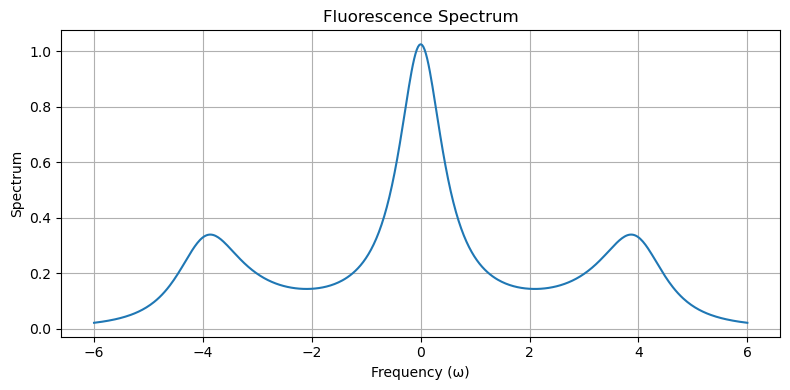

In [72]:
import numpy as np
from scipy.linalg import null_space
from scipy.sparse import kron, eye, identity, csc_matrix
from scipy.sparse.linalg import inv

# Parameters
Delta = 0.0          # Level splitting
Omega = 4.0          # Rabi frequency
Gamma = 1.0          # Atomic decay rate
steps = 501          # Number of frequency steps
omvec = np.linspace(-6, 6, steps) + 1e-10j  # Frequencies with small imaginary offset

# Operators
id2 = np.eye(2)
Id4 = np.eye(4)
SM = np.array([[0, 0], [1, 0]], dtype=complex)
SP = SM.conj().T

# Hamiltonians
H0 = Delta * SP @ SM
H1 = (Omega / 2) * (SP + SM)
H = H0 + H1

# Liouvillian components
LH = -1j * (np.kron(H, id2) - np.kron(id2, H.conj().T))
LGamma = (Gamma / 2) * (
    2 * np.kron(SM, SP.T) -
    np.kron(SP @ SM, id2) -
    np.kron(id2, SP @ SM).T
)

# Total Liouvillian
L = LH + LGamma

# Trace vector
trace_vec = np.array([1, 0, 0, 1], dtype=complex).reshape((1, 4))

# Steady-state solution
V0 = null_space(L)[:, 0]  # Take the first null vector
rho0 = V0 / (trace_vec @ V0)  # Normalize

# <SM> expectation value
SM_av = trace_vec @ np.kron(SM, id2) @ rho0

# SM - <SM> operator
dSM = np.kron(SM - SM_av * id2, id2)

# Spectrum computation
Spec = np.zeros(steps, dtype=float)
Id_big = np.eye(4)

for x, om in enumerate(omvec):
    resolvent = np.linalg.inv(1j * om * Id_big + L)
    Spec[x] = -2 * np.real(trace_vec @ np.kron(SP, id2) @ resolvent @ (dSM @ rho0))

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(omvec.real, Spec)
plt.xlabel("Frequency (ω)")
plt.ylabel("Spectrum")
plt.title("Fluorescence Spectrum")
plt.grid(True)
plt.tight_layout()
plt.show()